# Stock analysis

## Import

Libraries

In [1]:
from utils.init import *

from utils.analyse_price import *
from utils.analyse_fundementals import *
from utils.data import *
from utils.params import *

In [2]:
TICKER = 'CSL'
COUNTRY = 'AU'
first_end_of_quarter = '2020-06'
last_end_of_quarter = '2024-06'
historical_prices_dict = {}

## Get data

Run data

same_industry_500


,ASX code,Market Cap,weight
1754,TLX,6.844149e+09,0.386143
497,CU6,2.790681e+09,0.157449
1229,NEU,1.893756e+09,0.106845
1187,MSB,1.541409e+09,0.086965
1327,OPT,1.015653e+09,0.057303
1452,PYC,8.632254e+08,0.048703
503,CUV,7.003489e+08,0.039513
324,BOT,6.893344e+08,0.038892
925,IMM,4.509160e+08,0.025440
927,IMU,3.569880e+08,0.020141


,ASX code,Market Cap ($bn)
484,CSL,139.75


0.0


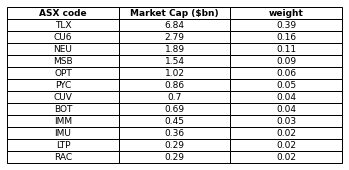

$LTP.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$CU6.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$LTP.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")
$CU6.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")
$LTP.AX: possibly delisted; no price data found  (1d 2021-01-01 -> 2021-12-31) (Yahoo error = "Data doesn't exist for startDate = 1609419600, endDate = 1640869200")
$LTP.AX: possibly delisted; no price data found  (1d 2022-01-01 -> 2022-12-31) (Yahoo error = "Data doesn't exist for startDate = 1640955600, endDate = 1672405200")


In [3]:
# read in data
interest_rate_df_dict = get_interest_rate(COUNTRY)
if COUNTRY == 'AU':
    asx_companies_directory_df = get_asx_companies_directory()
    asx_gics_df = get_asx_gics()

# get same gics tickers
if COUNTRY == 'AU':
    AU_top_list_dict = get_top_ASX_companies_list(asx_companies_directory_df)
    ASX_ticker_gics_dict = get_ASX_ticker_gics(TICKER, asx_gics_df)
    same_gics_ASX_tickers_dict = get_same_gics_ASX_tickers(asx_gics_df,
                                                           ASX_ticker_gics_dict, AU_top_list_dict)
    comparable_ASX_tickers_dict = get_comparable_ASX_tickers(
        TICKER, same_gics_ASX_tickers_dict)

    print(comparable_ASX_tickers_dict['type'])

    same_industry_ASX_tickers_mcap_df = get_same_gics_ASX_MCap_weights(TICKER,
                                                                       asx_companies_directory_df, comparable_ASX_tickers_dict)

# market value and weight
if COUNTRY == 'AU':
    same_industry_tickers_mcap_df = get_same_industry_tickers_mcap(
        same_industry_ASX_tickers_mcap_df)
    display(same_industry_tickers_mcap_df)

    ticker_mv_df = get_AU_ticker_mv_df(asx_companies_directory_df, TICKER)
    display(ticker_mv_df)

    ticker_proportion_of_market = get_AU_ticker_proportion_of_market(
        ticker_mv_df, same_industry_tickers_mcap_df)
    print(round(ticker_proportion_of_market, 2))

    plot_gics_mcap_weights(TICKER, same_industry_tickers_mcap_df)

    same_gics_industry_weight_dict = get_same_AU_gics_industry_weight_dict(
        same_industry_tickers_mcap_df)

# TODO: should be able to not need comparable_ASX_ticker_dict
analysis_needed_ticker_list = get_analysis_needed_ticker_list(
    TICKER, comparable_ASX_tickers_dict, index_tickers_list)
historical_prices_dict = get_historical_prices_for_interested_list(
    analysis_needed_ticker_list, index_tickers_list, historical_prices_dict)

In [4]:
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    monthly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['monthly'], 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    quarterly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['quarterly'], 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    yearly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['annualy'], 'Y')

In [5]:
# ASX ONLY

monthly_returns_df_dict = get_gics_industry_weighted_mean(
    monthly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict, index_tickers_list, 'M', comparable_tickers=comparable_ASX_tickers_dict)
quarterly_returns_df_dict = get_gics_industry_weighted_mean(
    quarterly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict, index_tickers_list, 'Q', comparable_tickers=comparable_ASX_tickers_dict)
yearly_returns_df_dict = get_gics_industry_weighted_mean(
    yearly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict, index_tickers_list, 'Y', comparable_tickers=comparable_ASX_tickers_dict)

In [6]:
get_monthly_stats(monthly_returns_df_dict, TICKER,
                  first_end_of_quarter, last_end_of_quarter)

{'mean (%)': 0.35,
 'std (%)': 5.03,
 'mean (-rf) (%)': 0.13,
 'std (-rf) (%)': 5.02,
 'n': 49,
 'sharpe': 0.09,
 'CAPM beta': 0.43,
 'CAPM alpha': 0.37}

In [7]:
stats_dict = {}

for ticker in monthly_returns_df_dict:
    stats_dict[ticker] = get_monthly_stats(
        monthly_returns_df_dict, ticker, first_end_of_quarter, last_end_of_quarter)

stats_df = pd.DataFrame(stats_dict).T

In [8]:
stats_df = get_stats_df(TICKER, stats_df, comparable_ASX_tickers_dict,
                        index_tickers_list, same_industry_tickers_mcap_df)

In [9]:
stats_df

,mean (%),std (%),mean (-rf) (%),std (-rf) (%),n,sharpe,CAPM beta,CAPM alpha
CSL,0.350000,5.030000,0.130000,5.020000,49.000000,0.090000,0.430000,0.370000
BOT,6.640000,24.940000,6.420000,24.930000,49.000000,0.890000,2.700000,4.060000
CU6,5.830000,21.430000,5.550000,21.390000,34.000000,0.900000,1.530000,5.690000
CUV,-0.150000,12.510000,-0.370000,12.510000,49.000000,-0.100000,0.700000,-0.890000
IMM,2.580000,18.390000,2.360000,18.400000,49.000000,0.440000,2.050000,1.500000
IMU,6.060000,38.890000,5.840000,38.910000,49.000000,0.520000,3.130000,5.300000
LTP,22.570000,56.170000,22.230000,56.160000,6.000000,1.370000,-2.930000,25.210000
MSB,0.520000,26.470000,0.290000,26.450000,49.000000,0.040000,2.800000,2.850000
NEU,7.500000,24.970000,7.270000,24.960000,49.000000,1.010000,2.440000,5.380000
OPT,-2.870000,16.810000,-3.090000,16.800000,49.000000,-0.640000,0.690000,4.580000


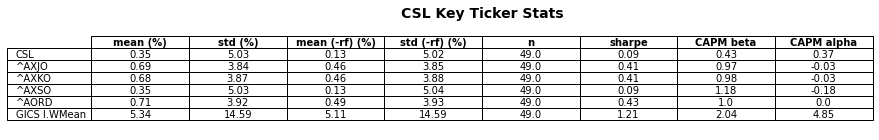

In [10]:
plot_key_ticker_stats_table(stats_df, TICKER, comparable_ASX_tickers_dict)

In [11]:
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)

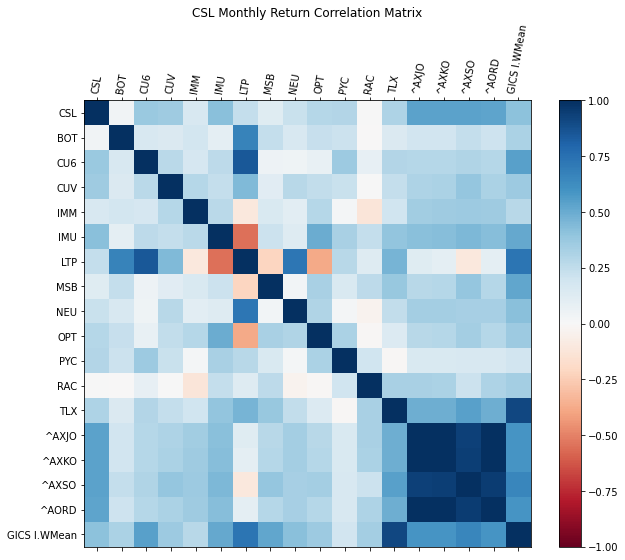

In [12]:
plot_correlation(correlation_df, ticker=TICKER)

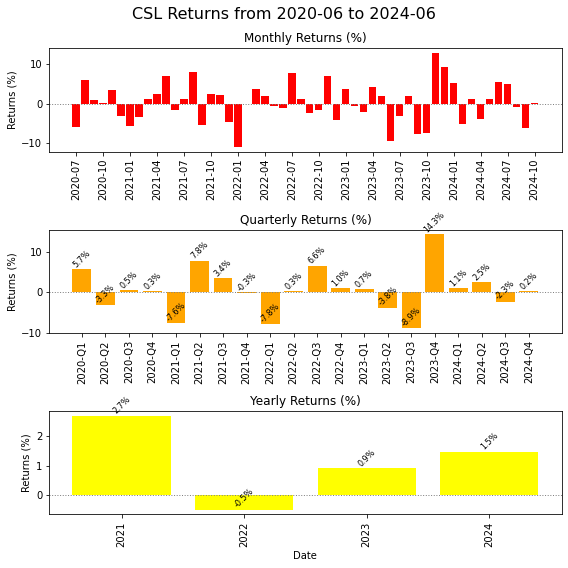

In [13]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': TICKER,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

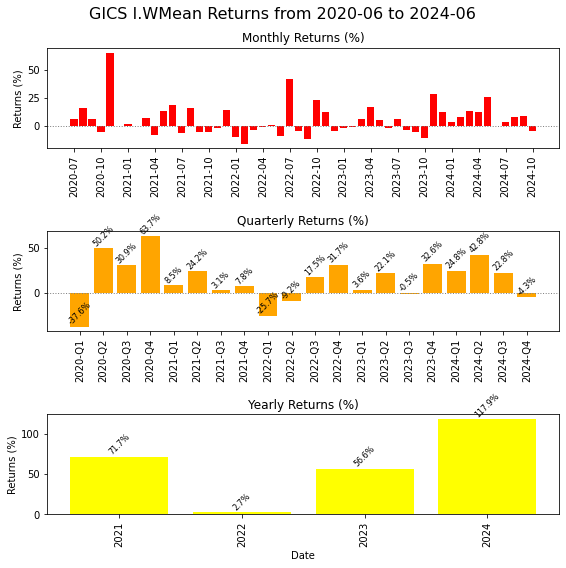

In [14]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict,
                'ticker': 'GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else 'GICS S.WMean',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter,
                'underlying_ticker': TICKER})

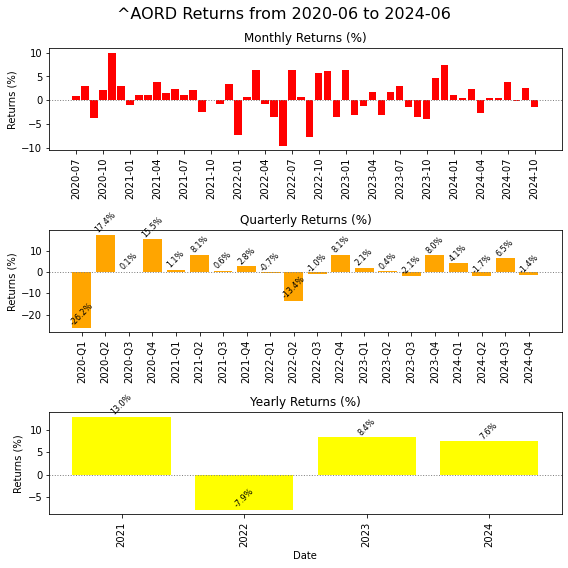

In [15]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': '^AORD',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

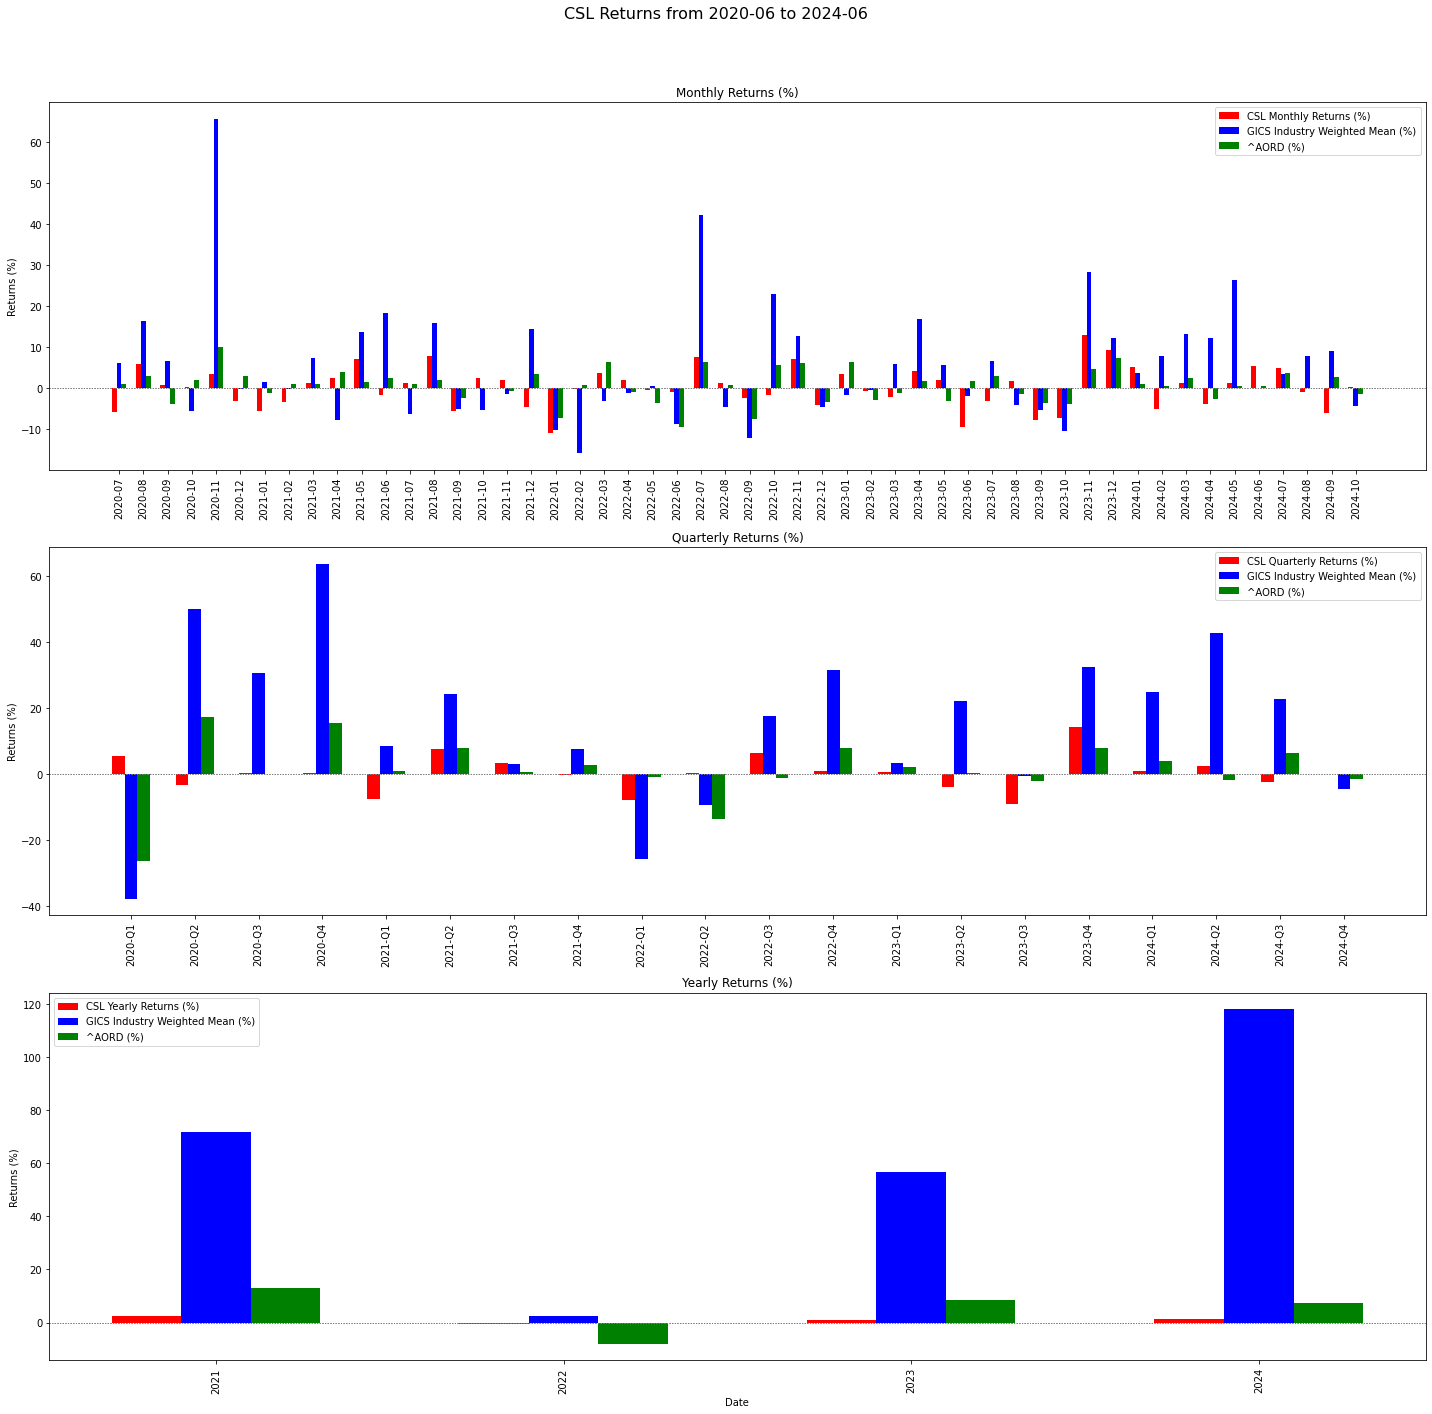

In [16]:
plot_returns_comparative(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                            'quarterly_returns_df_dict': quarterly_returns_df_dict,
                            'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                            'first_end_of_quarter': first_end_of_quarter,
                            'last_end_of_quarter': last_end_of_quarter,
                            'comparable_tickers': comparable_ASX_tickers_dict})

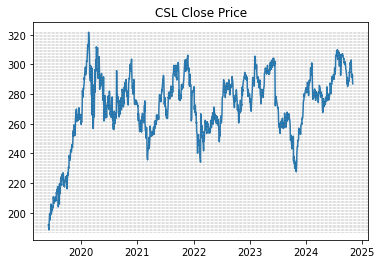

In [17]:
plot_close_price_with_dollar_lines(TICKER, historical_prices_dict)

In [18]:
historical_dividends = get_historical_dividends(TICKER, historical_prices_dict)
historical_dividends

,Date,Dividends
70,2019-09-10,1.454545
196,2020-03-11,1.471271
324,2020-09-10,1.469578
444,2021-03-04,1.349073
571,2021-09-02,1.589654
698,2022-03-07,1.422903
825,2022-09-06,1.758307
952,2023-03-09,1.621458
1080,2023-09-11,2.007782
1206,2024-03-11,1.798942


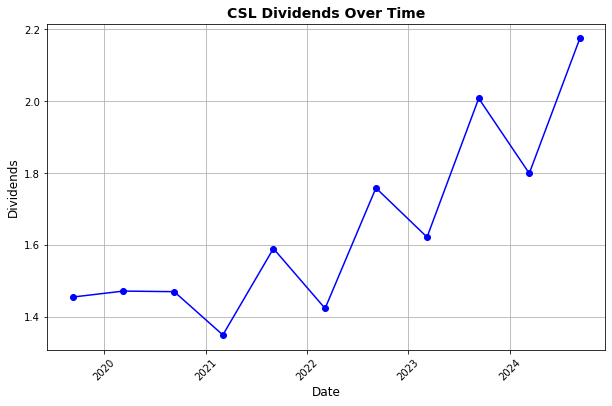

In [19]:
plot_dividends_over_time(TICKER, historical_prices_dict)

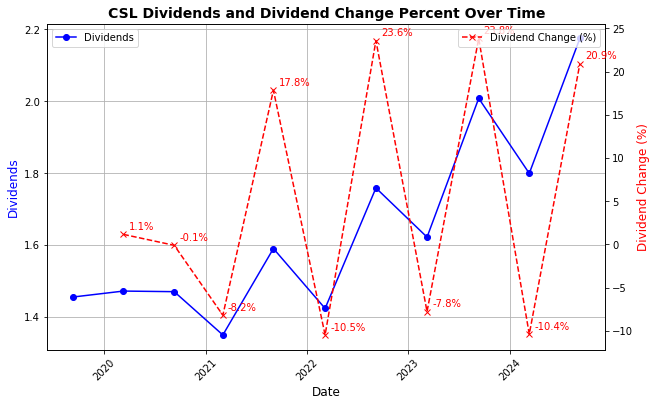

In [20]:
plot_dividends(TICKER, historical_dividends, historical_prices_dict)

In [21]:
historical_splits = get_historical_splits(TICKER, historical_prices_dict)
historical_splits

,Date,Stock Splits


In [22]:
plot_splits_over_time(TICKER, historical_prices_dict)

# fundementals

In [23]:
interested_ticker_raw_fundementals_stats, interested_ticker_key_interested_fundementals_stats, interested_ticker_key_interested_fundementals_stats_pct_change, object = get_fundementals_dfs(
    first_end_of_quarter, historical_prices_dict, TICKER)

In [24]:
interested_ticker_raw_fundementals_stats

,Total Debt,Stockholders Equity,Share Issued,Current Liabilities,Current Assets,Free Cash Flow,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,EBITDA,EBIT,Gross Profit,Operating Expense,Net Income,Total Revenue,Interest Expense,Net Profit,Average Shareholder Equity,Total Asset,Last Close Price,Dividends
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.396728,NaN
2021-06-30,3185000000.0,5501000000.0,623033791.0,2975000000.0,3675000000.0,555000000.0,120000000.0,114000000.0,-1727000000.0,-2442000000.0,2632000000.0,2036000000.0,-2058000000.0,10681000000.0,215000000.0,362000000.0,5.501000e+09,8476000000.0,6.873214,0.82
2022-06-30,2878000000.0,6516000000.0,672747233.0,7607000000.0,8631000000.0,591000000.0,84000000.0,NaN,2114000000.0,1389000000.0,2280000000.0,869000000.0,860000000.0,13011000000.0,207000000.0,NaN,6.008500e+09,14123000000.0,7.409889,0.50
2023-06-30,2883000000.0,5121000000.0,672747233.0,4187000000.0,4575000000.0,288000000.0,115000000.0,NaN,-857000000.0,-1585000000.0,2325000000.0,2000000000.0,-1264000000.0,13869000000.0,254000000.0,NaN,5.818500e+09,9308000000.0,9.951843,0.18
2024-06-30,2728000000.0,5431000000.0,672747233.0,4557000000.0,4860000000.0,1402000000.0,151000000.0,4000000.0,2057000000.0,1310000000.0,3255000000.0,2263000000.0,711000000.0,13122000000.0,309000000.0,837000000.0,5.276000e+09,9988000000.0,10.498952,0.49


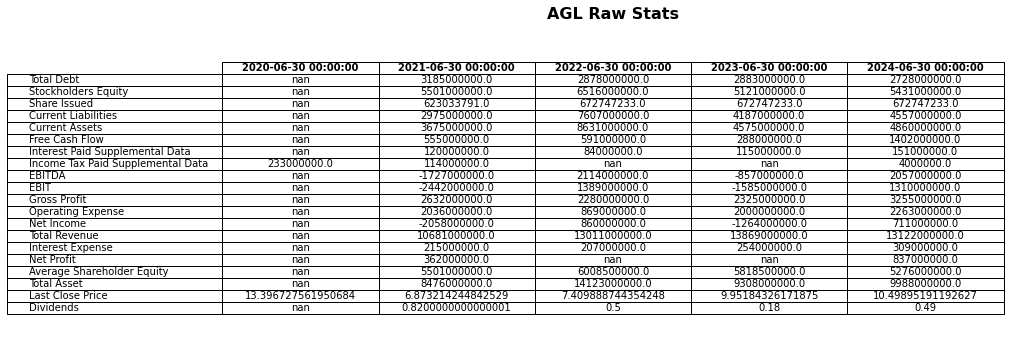

In [25]:
plot_raw_fundementals_stats_table(
    interested_ticker_raw_fundementals_stats, TICKER)

In [26]:
interested_ticker_key_interested_fundementals_stats

,Net Profit Margin,Net Income Margin,RoE,RoA,P/E,P/B,D/E,Current Ratio,Interest Coverage Ratio,DPS
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,0.03,-0.19,0.07,0.04,-2.08,0.78,0.58,1.24,-20.35,0.82
2022-06-30,NaN,0.07,NaN,NaN,5.80,0.77,0.44,1.13,16.54,0.50
2023-06-30,NaN,-0.09,NaN,NaN,-5.30,1.31,0.56,1.09,-13.78,0.18
2024-06-30,0.06,0.05,0.16,0.08,9.93,1.30,0.50,1.07,8.68,0.49


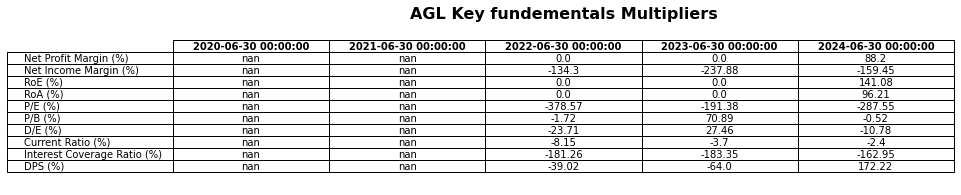

In [27]:
plot_key_fundementals_multipliers_table(
    interested_ticker_key_interested_fundementals_stats_pct_change, TICKER)

In [28]:
interested_ticker_key_interested_fundementals_stats_pct_change

,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,0.0,-134.30,0.00,0.00,-378.57,-1.72,-23.71,-8.15,-181.26,-39.02
2023-06-30,0.0,-237.88,0.00,0.00,-191.38,70.89,27.46,-3.70,-183.35,-64.00
2024-06-30,88.2,-159.45,141.08,96.21,-287.55,-0.52,-10.78,-2.40,-162.95,172.22


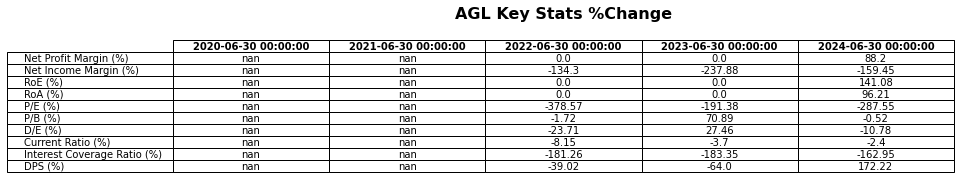

In [29]:
plot_key_fundementals_multipliers_pct_change_table(
    interested_ticker_key_interested_fundementals_stats_pct_change, TICKER)

In [30]:
raw_fundementals_stats_dict = dict()
object_dict = dict()

for ticker in comparable_ASX_tickers_dict['list']:
    ticker = ticker.split('.')[0]
    print('\n', ticker)
    raw_stats, key_interested_stats, key_interested_stats_pct_change, object = get_fundementals_dfs(
        first_end_of_quarter, historical_prices_dict, ticker)

    raw_fundementals_stats_dict[ticker] = raw_stats
    object_dict[ticker] = object


 GNE
Interest Paid Supplemental Data not found for ticker GNE: 'Interest Paid Supplemental Data'
Missing data for Net Profit for ticker GNE: 'Interest Paid Supplemental Data'
Missing data for Interest Coverage Ratio for ticker GNE: 'Interest Paid Supplemental Data'


In [31]:
interpolated_fundementals_stats_dict = {}
for key in raw_fundementals_stats_dict.keys():
    interpolated_fundementals_stats = interpolate_fundementals_stats(
        raw_fundementals_stats_dict, key)
    interpolated_fundementals_stats_dict[key] = interpolated_fundementals_stats

In [32]:
interested_dates = [pd.to_datetime(
    dt.strftime('%Y-%m')) for dt in interested_ticker_key_interested_fundementals_stats_pct_change.index]

In [33]:
agg_interpolated_fundementals_stats_df_dict = {}
for key in interpolated_fundementals_stats_dict:
    agg_interpolated_fundementals_stats_df = agg_interpolated_fundementals_stats(
        interpolated_fundementals_stats_dict[key], interested_dates)
    agg_interpolated_fundementals_stats_df_dict[key] = agg_interpolated_fundementals_stats_df

In [34]:
key_interested_fundementals_stats_dict = {}
key_interested_fundementals_stats_pct_change_dict = {}

for key in agg_interpolated_fundementals_stats_df_dict:
    stock_fundementals = process_stock_fundementals(
        agg_interpolated_fundementals_stats_df_dict[key], object_dict[key], first_end_of_quarter, historical_prices_dict, key)

    key_interested_stats = get_key_interested_fundementals_stats(
        stock_fundementals)

    key_interested_stats_pct_change = get_key_interested_fundementals_stat_pct_change(
        key_interested_stats
    )

    key_interested_fundementals_stats_dict[key] = key_interested_stats
    key_interested_fundementals_stats_pct_change_dict[key] = key_interested_stats_pct_change

Missing data for Net Profit for ticker GNE: 'Interest Paid Supplemental Data'
Missing data for Interest Coverage Ratio for ticker GNE: 'Interest Paid Supplemental Data'


In [35]:
weighted_GICS_key_interested_fundementals_stats = get_weighted_fundementals(
    key_interested_fundementals_stats_dict, same_gics_industry_weight_dict)

In [36]:
weighted_GICS_key_interested_fundementals_stats.index = weighted_GICS_key_interested_fundementals_stats.index

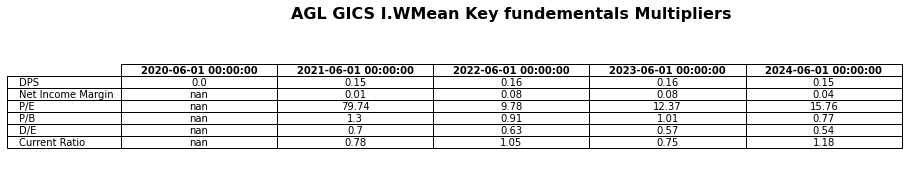

In [37]:
plot_key_fundementals_multipliers_table(
    weighted_GICS_key_interested_fundementals_stats.astype(float).round(2),  f'{TICKER} GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else f'{TICKER} GICS S.WMean')

In [38]:
weighted_GICS_key_interested_fundementals_stats

,DPS,Net Income Margin,P/E,P/B,D/E,Current Ratio
2020-06-01,0.000000,NaN,NaN,NaN,NaN,NaN
2021-06-01,0.154440,0.010415,79.743140,1.302040,0.695911,0.784953
2022-06-01,0.159969,0.078418,9.780172,0.912049,0.627569,1.053116
2023-06-01,0.157926,0.082130,12.366645,1.005882,0.568038,0.752500
2024-06-01,0.146219,0.043316,15.757428,0.771396,0.541710,1.181120


In [39]:
weighted_GICS_key_interested_fundementals_stats_pct_change = get_key_interested_fundementals_stat_pct_change(
    weighted_GICS_key_interested_fundementals_stats)

In [40]:
weighted_GICS_key_interested_fundementals_stats_pct_change.index = interested_ticker_key_interested_fundementals_stats_pct_change.index

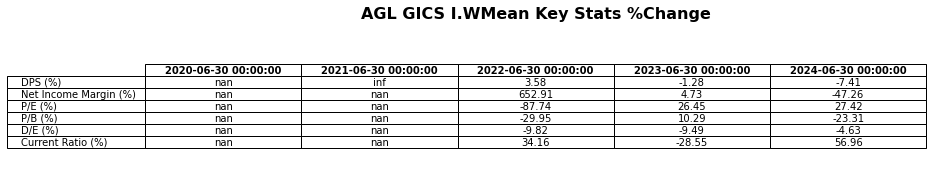

In [41]:
plot_key_fundementals_multipliers_pct_change_table(
    weighted_GICS_key_interested_fundementals_stats_pct_change, f'{TICKER} GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else f'{TICKER} GICS S.WMean')

In [42]:
weighted_GICS_key_interested_fundementals_stats

,DPS,Net Income Margin,P/E,P/B,D/E,Current Ratio
2020-06-01,0.000000,NaN,NaN,NaN,NaN,NaN
2021-06-01,0.154440,0.010415,79.743140,1.302040,0.695911,0.784953
2022-06-01,0.159969,0.078418,9.780172,0.912049,0.627569,1.053116
2023-06-01,0.157926,0.082130,12.366645,1.005882,0.568038,0.752500
2024-06-01,0.146219,0.043316,15.757428,0.771396,0.541710,1.181120


Column Net Profit Margin not found for GICS: 'Net Profit Margin'


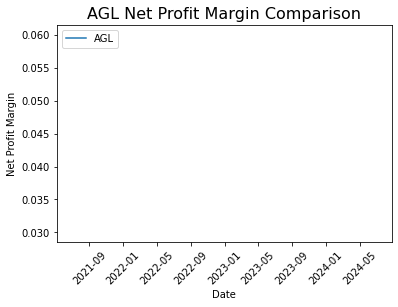

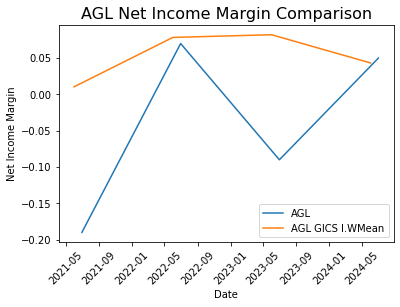

Column RoE not found for GICS: 'RoE'


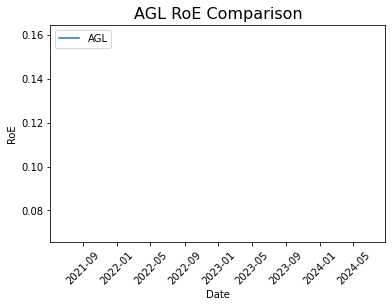

Column RoA not found for GICS: 'RoA'


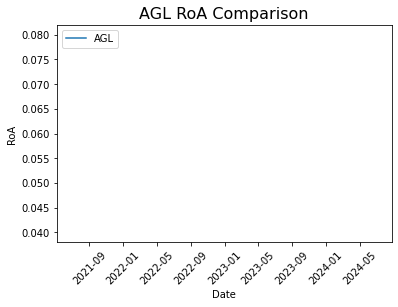

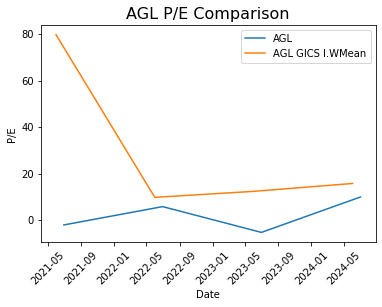

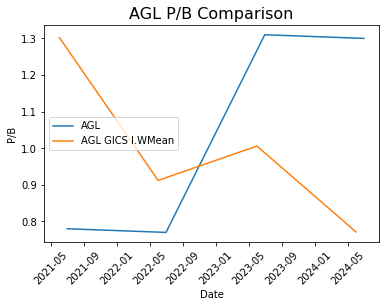

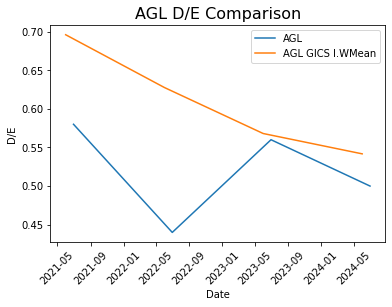

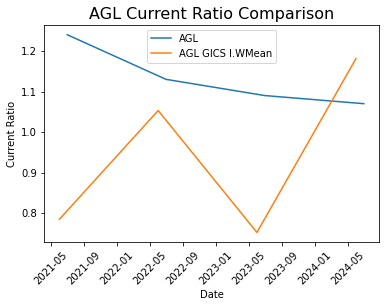

Column Interest Coverage Ratio not found for GICS: 'Interest Coverage Ratio'


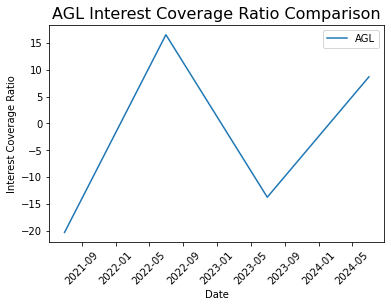

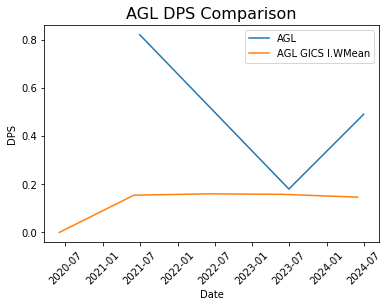

In [70]:
plot_key_fundamentals_multipliers(
    interested_ticker_key_interested_fundementals_stats, weighted_GICS_key_interested_fundementals_stats, TICKER, comparable_ASX_tickers_dict['type'])

In [71]:
pdf = FPDF()

# TITLE
# Add a page
pdf.add_page()
# Set font for the title
pdf.set_font("Arial", 'B', 16)  # Bold and size 16 for the title
title = f"Stock Analysis of Ticker: {TICKER}"
pdf.cell(200, 10, txt=title, ln=True, align='C')

# Comparable Ticker Universe
# Set font for the content
pdf.set_font("Arial", 'B', size=12)
pdf.cell(200, 10, txt=f"Comparable tickers universe", ln=True, align='L')
pdf.set_font("Arial", size=10)
text = f"{'same INDUSTRY of TOP500' if 'industry' in comparable_ASX_tickers_dict['type'] else 'same SECTOR of MCAP$1BN+'}"
pdf.cell(200, 10, txt=text, ln=True, align='L')

# Retrieve and convert the Market Cap of the stock in question (from ticker_mv) to billions
ticker_market_cap_billion = round(
    ticker_mv_df.iloc[0]['Market Cap ($bn)'], 2)
ticker_proportion_of_market = ticker_mv_df['Market Cap ($bn)'].values[0] / \
    same_industry_tickers_mcap_df['Market Cap ($bn)'].sum()
universe_market_value_billion = round(
    same_industry_tickers_mcap_df['Market Cap ($bn)'].sum(), 2)
pdf.cell(
    200, 10, txt=f"{TICKER} has a market value of ${ticker_market_cap_billion}B and is {round(ticker_proportion_of_market, 2)} times the universe market value of ${universe_market_value_billion}B,", align='L')

# KEY STATS
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Key Stats", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(
    f'../outputs/{TICKER}_key_ticker_stats_table.png', x=10, y=None, w=125)

# COMPARATIVE RETURNS PLOTS
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Comparative Returns Plot", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_comparative_returns.png', x=10, y=None, w=150)

# TICKER RETURN CHART
pdf.add_page()  # Add a new page for the plot
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Returns Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_returns.png', x=10, y=None, w=100)

# SECTOR/INDUSTRY WMEAN RETURNS CHART
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(
    200, 10, txt=f"{TICKER} {'Industry' if 'industry' in comparable_ASX_tickers_dict['type'] else 'Sector'} Weighted Mean Returns Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_WMean_returns.png', x=10, y=None, w=100)

# ^AORD CHART
pdf.add_page()
pdf.set_font("Arial", 'B', 12)
pdf.cell(
    200, 10, txt=f"{TICKER} ^AORD Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/^AORD_returns.png', x=10, y=None, w=100)

# CLOSE PRICE CHART
pdf.add_page()  # Add a new page for the plot
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Close Price Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_close_price.png', x=10, y=None, w=75)

# DIVIDENDS
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Dividends", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_dividends_over_time.png', x=10, y=None, w=75)

# key multipliers
pdf.add_page()
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Key Multipliers", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(
    f'../outputs/{TICKER}_interested_ticker_key_interested_stats.png', x=10, y=None, w=125)

# gics multipliers
pdf.image(
    f"../outputs/{TICKER} GICS {'I' if 'industry' in comparable_ASX_tickers_dict['type'] else 'S'}.WMean_interested_ticker_key_interested_stats.png", x=10, y=None, w=125
)

# key multiplier pct change
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(
    200, 10, txt=f"{TICKER} Key Multipliers Pct Change", ln=True, align='L')
pdf.ln(5)
pdf.image(
    f'../outputs/{TICKER}_interested_ticker_key_interested_stats_pct_change.png', x=10, y=None, w=125)

# gics multipliers pct change
pdf.image(
    f"../outputs/{TICKER} GICS {'I' if 'industry' in comparable_ASX_tickers_dict['type'] else 'S'}.WMean_interested_ticker_key_interested_stats_pct_change.png", x=10, y=None, w=125
)

# plots of key multipliers
pdf.add_page()
images = [
    f'../outputs/{TICKER}_P_B_comparison.png',
    f'../outputs/{TICKER}_P_E_comparison.png',
    f'../outputs/{TICKER}_Net Income Margin_comparison.png',
    f'../outputs/{TICKER}_Net Profit Margin_comparison.png',
    f'../outputs/{TICKER}_ROE_comparison.png',
    f'../outputs/{TICKER}_ROA_comparison.png',
    f'../outputs/{TICKER}_D_E_comparison.png',
    f'../outputs/{TICKER}_Current Ratio_comparison.png',
    f'../outputs/{TICKER}_Interest Coverage Ratio_comparison.png',
    f'../outputs/{TICKER}_DPS_comparison.png'
]

# Set image dimensions and spacing
width = 60  # Adjust width to make images smaller
height_spacing = 50  # Adjust vertical space between rows
images_per_row = 2  # Number of images per row

# Loop through images, placing them in a grid
x, y = 10, 10  # Starting coordinates
for i, image in enumerate(images):
    pdf.image(image, x=x, y=y, w=width)

    # Update x and y positions for next image
    if (i + 1) % images_per_row == 0:  # Move to the next row
        x = 10
        y += height_spacing
    else:
        x += width + 10  # Move to the next column

# APPENDIX
pdf.add_page()  # Add a new page for the appendix
# Set font for the title
pdf.set_font("Arial", 'B', 12)  # Bold and size 16 for the title

# APPENDIX TITLE
title = f"Appendix"
pdf.cell(200, 10, txt=title, ln=True, align='C')

# CORRELATION
pdf.set_font("Arial", 'B', 12)
pdf.cell(200, 10, txt=f"{TICKER} Correlation Matrix Plot", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_correlation_matrix.png', x=10, y=None, w=140)

# SPLITS
pdf.set_font("Arial", 'B', 12)
pdf.cell(200, 10, txt=f"{TICKER} Splits", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(
    f'../outputs/{TICKER}_stock_splits_over_time.png', x=10, y=None, w=75)

# INDUSTRY TICKER MCAP TABLE
pdf.add_page()
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(
    200, 10, txt=f"{TICKER} Same {'Industry' if 'industry' in comparable_ASX_tickers_dict['type'] else 'Sector'} Ticker MCAP Table", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(
    f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png', x=10, y=None, w=75)

pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.image(
    f"../outputs/{TICKER}_interested_ticker_raw_stats.png", x=10, y=None, w=100)

# Save the PDF after adding the image
pdf.output(f"../reports/{TICKER}_comparable_tickers_report_with_plot.pdf")

''